## Fitting profiles with Markov Chain Monte Carlo
This is a jupyter notebook intended to fit stellar density profiles to 
a bunch of clusters simulated. It fits the exponential radius, ellipticity, angular position, background density and center shift in ra and dec.

The code runs reading the position of the stars in a catalog and fitting the pars. After the fitting, the results should be compared to the
truth table (the parameters of the clusters simulated).

Open a terminal and run the following commands to create and activate a new environment and install dependencies:
```
conda create --name emcee_env
conda activate emcee_env
conda install -c astropy emcee
conda install -c conda-forge matplotlib
conda install astropy
conda install -c astropy corner
```
Activate the environment (if you are running the code in Linea's jupyter notebook). Ok, now you are ready to run the code. </br>
You can run this code on any machine since you follow the steps above to create an env and install dependencies.

TODO (Ana Clara, Amanda):
- insert documentation in the functions;
- plot the chains to make sure the cuts in steps are ok to all pars;
- format the results into a single file;
- add cells to compare the results to the truth table.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import emcee
import astropy.io.fits as fits
import corner
from multiprocessing import Pool

Below are a few functions (that will be documented in near future!) to provide the results of the fitting.
This is very similar to the main example available on https://emcee.readthedocs.io/en/stable/tutorials/line/ .
Please, visit that page to have a big picture of the fitting.

#                HPX      re          ell           pa_kick_     robg   shift_ra    shift dec
Pars (ideal): 35934.0 0.15359148315490373 0.09 105.53 ---- 0.00 0.00
Kick-off:  35934.0 0.15359148315490373 0.1 1.0553 100.49797880886848 0.0 0.0
Best-fitting: 35934.0 0.05258656291402104 0.06193973261485514 122.96531704268305 100.44442248706213 -0.00019358513860459018 0.0020436290112119844


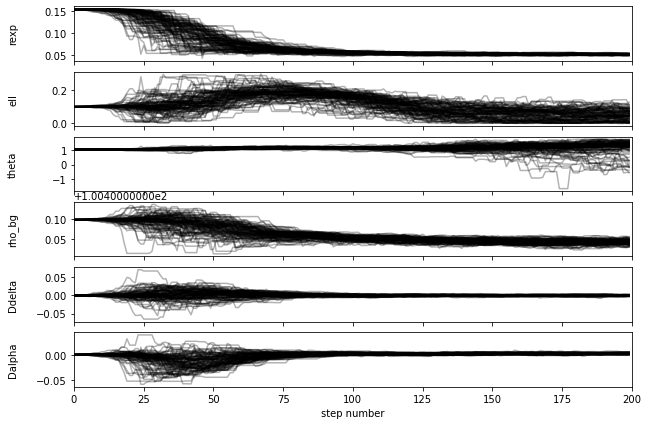

Pars (ideal): 35935.0 0.22917372628576235 0.02 78.61 ---- 0.00 0.00
Kick-off:  35935.0 0.22917372628576235 0.1 0.7861 100.49047225816723 0.0 0.0
Best-fitting: 35935.0 0.07647341562568782 0.05494538075859899 71.13618770233946 100.45505526925879 -0.0030624089732021824 -0.0003356401758802675


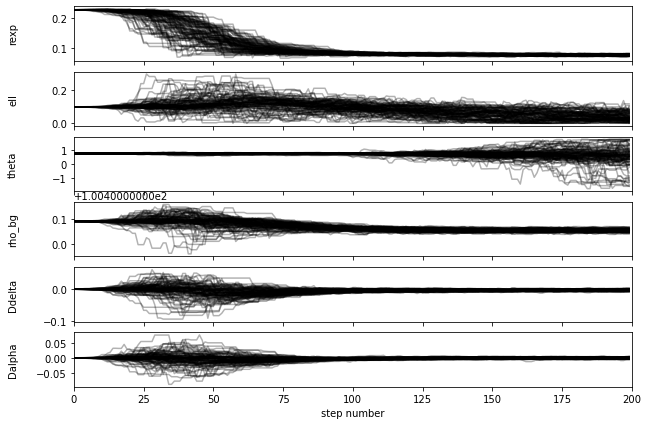

Pars (ideal): 35949.0 0.17655777236379636 0.08 124.97 ---- 0.00 0.00
Kick-off:  35949.0 0.17655777236379636 0.1 1.2497 100.49047225816723 0.0 0.0
Best-fitting: 35949.0 0.06061971851693434 0.11791934744898418 111.72101578099081 100.44212194915553 0.0015226691241153108 -0.0003384475956901065


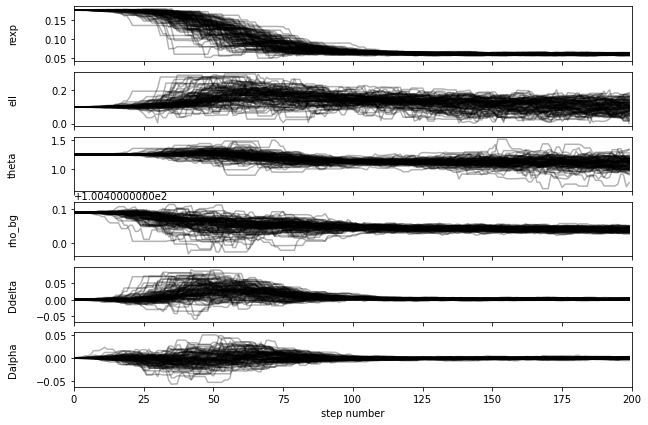

Pars (ideal): 35950.0 0.2370606546968382 0.11 60.92 ---- 0.00 0.00
Kick-off:  35950.0 0.2370606546968382 0.1 0.6092 100.4559977290207 0.0 0.0
Best-fitting: 35950.0 0.07835188882396454 0.21373421039208765 65.30243814183859 100.42991592784261 0.0005593422215617785 0.0013468169054798482


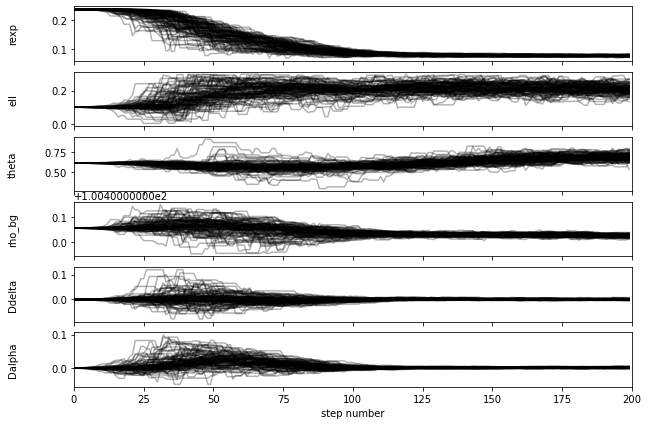

Pars (ideal): 35951.0 0.2019712880038019 0.1 60.19 ---- 0.00 0.00
Kick-off:  35951.0 0.2019712880038019 0.1 0.6019 100.45015930069749 0.0 0.0
Best-fitting: 35951.0 0.06416576656545181 0.09895209966593768 63.08743514271017 100.4110427862206 0.0012321194870985107 0.0011507788515526915


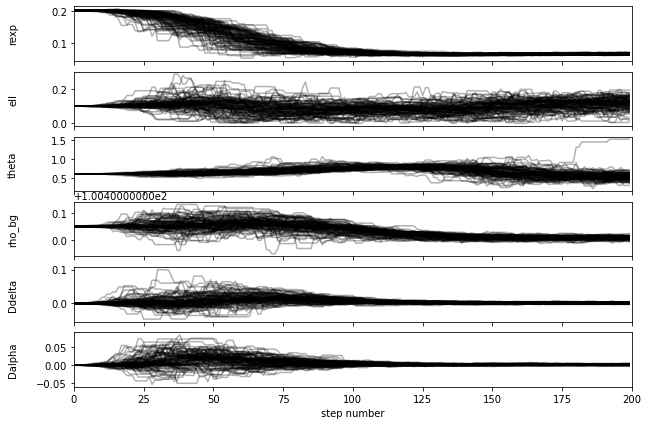

Pars (ideal): 35953.0 0.18416744125160092 0.17 99.82 ---- 0.00 0.00
Kick-off:  35953.0 0.18416744125160092 0.1 0.9982 100.48824809499648 0.0 0.0
Best-fitting: 35953.0 0.06401946735207392 0.0961880085559767 91.42686410292532 100.44002300241561 0.002230299849474126 0.001459258189472669


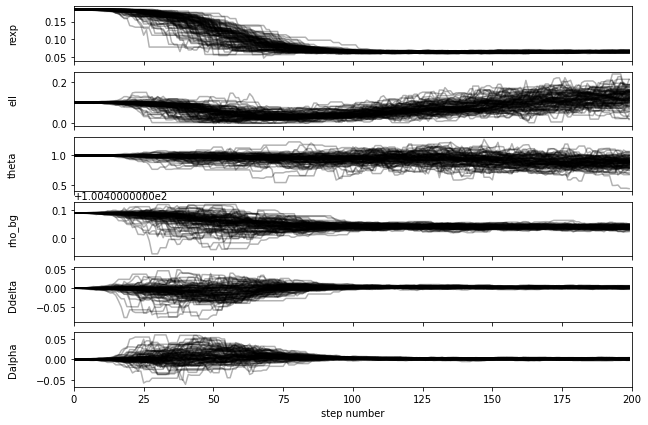

Pars (ideal): 35954.0 0.15903516727242517 0.03 91.03 ---- 0.00 0.00
Kick-off:  35954.0 0.15903516727242517 0.1 0.9103 100.49102829895992 0.0 0.0


In [ ]:
def lnprior(theta):
    re, ell, th, bg, xc, yc = theta
    if 0.01 < re < 20. and 0.0 < ell < 0.3 and -1.8 < th < 1.8 and 0. < bg < 500. and -3. < xc < 3. and -3. < yc < 3.:
        return 0
    return -np.inf


def lnlike(theta, RA, DEC):
    re, ell, th, bg, xc, yc = theta
    dX = (RA-(ra0+xc/60.))*np.cos(np.radians(dec0))
    dY = (DEC-(dec0+yc/60.))
    ri = 60.*np.sqrt(((dX*np.cos(np.radians(100*th))-dY*np.sin(np.radians(100*th)))/(1.-ell))
                     ** 2.+(dX*np.sin(np.radians(100*th))+dY*np.cos(np.radians(100*th)))**2.)
    s0 = (len(RA)-bg*3600.)/((1-ell)*2.*np.pi*re**2)
    if not np.isfinite(2.*np.sum(np.log(bg+s0*np.exp(-ri/re)))):
        return -np.inf
    return 2.*np.sum(np.log(bg+s0*np.exp(-ri/re)))


def lnprob(theta, RA, DEC):
    lp = lnprior(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp + lnlike(theta, RA, DEC)


# Some definitions:
R0 = 1.0
# ra0, dec0, reinf, resup, thmin, thmax = 67.3156, -23.8368, 0.1, 10., 0.0, 180.
HPX_, ra0_, dec0_, re_kick_, ell_kick_, pa_kick_, dist = np.loadtxt(
    'star_clusters_simulated.dat', usecols=(0, 6, 7, 8, 9, 10, 12), unpack=True)

# Converting exponential radius from parsecs to arcmin
re_kick = 60. * (180. / np.pi) * np.arctan(re_kick_ / dist)

hdu = fits.open('des_mockcat_for_detection.fits', memmap=True)
RA = hdu[1].data.field('ra')
DEC = hdu[1].data.field('dec')
MAGG = hdu[1].data.field('mag_g_with_err')
MAGGERR = hdu[1].data.field('magerr_g')
MAGR = hdu[1].data.field('mag_g_with_err')
MAGRERR = hdu[1].data.field('magerr_r')
hdu.close()

print('#                HPX      re          ell           pa_kick_     robg   shift_ra    shift dec')
for i in range(len(ra0_)):
    print('Pars (ideal):', HPX_[i], re_kick[i], ell_kick_[i], pa_kick_[i], '----', '0.00', '0.00')
    reinf = 0.5 * re_kick[i]
    resup = 1.5 * re_kick[i]
    thmin = pa_kick_[i] - 45.
    thmax = pa_kick_[i] + 45.
    ra0 = ra0_[i]
    dec0 = dec0_[i]

    R = 60.*np.sqrt(((np.cos(np.radians(dec0))*(ra0-RA))**2.)+(DEC-dec0)**2)

    re_ml = (reinf + resup)/2.
    ell_ml = 0.1
    th_ml = (thmin + thmax)/200.
    idbg = (R > R0)
    robg = float(len(RA[idbg]))/(3600.-np.pi*(R0)**2)  # stars/arcmin^2
    N_star = (len(RA)-robg*3600.)
    s_ml = N_star/(2.*np.pi*re_ml**2)
    xc_ml = 0.0
    yc_ml = 0.0
    result = re_ml, ell_ml, th_ml, robg, xc_ml, yc_ml
    print('Kick-off: ', HPX_[i], re_ml, ell_ml, th_ml, robg, xc_ml, yc_ml)

    ndim, nwalkers = 6, 100  # 300
    pos = [result + 1e-4*np.random.randn(ndim) for j in range(nwalkers)]
    with Pool() as pool:
        sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob, args=(RA, DEC), pool=pool)
        # sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob, args=(RA, DEC))
        sampler.run_mcmc(pos, 200)  # 500
    samples = sampler.chain[:, 120:, :].reshape((-1, ndim))

    samples[:, 2] = 100.*(samples[:, 2])
    re_mcmc, ell_mcmc, th_mcmc, robg_mcmc, xc_mcmc, yc_mcmc = map(lambda v: (
        v[1], v[2]-v[1], v[1]-v[0]), zip(*np.percentile(samples, [16, 50, 84], axis=0)))
    print('Best-fitting:', HPX_[i], re_mcmc[0], ell_mcmc[0], th_mcmc[0], robg_mcmc[0], xc_mcmc[0], yc_mcmc[0])
# Plotting data
    fig = corner.corner(samples, labels=["$re$", "$ell$", "$th$", r"$\rho_{bg}$", r"$\Delta\alpha$", r"$\Delta\delta$"], truths=[
                        re_mcmc[0], ell_mcmc[0], th_mcmc[0], robg_mcmc[0], xc_mcmc[0], yc_mcmc[0]], quantiles=[0.16, 0.5, 0.84], show_titles=True, plot_contours=True)
    plt.savefig(str(HPX_[i]) + '_plus.png')
    plt.close()

    L = np.zeros(len(RA))
    dX = (RA-(ra0+xc_mcmc[0]/60.))*np.cos(np.radians(dec0))
    dY = (DEC-(dec0+yc_mcmc[0]/60.))
    ri = 60.*np.sqrt(((dX*np.cos(np.radians(100*th_mcmc[0]))-dY*np.sin(np.radians(100*th_mcmc[0])))/(
        1.-ell_mcmc[0]))**2.+(dX*np.sin(np.radians(100*th_mcmc[0]))+dY*np.cos(np.radians(100*th_mcmc[0])))**2.)
    L = (np.exp(-ri/re_mcmc[0]))

    fig, axes = plt.subplots(6, figsize=(10, 7), sharex=True)
    samples = sampler.get_chain()
    labels = ["rexp", "ell", "theta", "rho_bg", "Ddelta", "Dalpha"]
    for i in range(ndim):
        ax = axes[i]
        ax.plot(samples[:, :, i], "k", alpha=0.3)
        ax.set_xlim(0, len(samples))
        ax.set_ylabel(labels[i])
        ax.yaxis.set_label_coords(-0.1, 0.5)

    axes[-1].set_xlabel("step number"); plt.show()

#a = open('J0429_stars_list_profile.dat','w')
# for j in range(len(RA)):
#    if (L[j]<0.):
#        L[j]=0.
#    print >> a, RA[j], DEC[j], MAGG[j], MAGR[j], ERRG[j], ERRR[j], SM[j], L[j]
# a.close